## Import e funzioni utili

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as snsfrom 
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
import sklearn
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib

local = False

LOCAL_URL = "dropoutData/"
CLOUD_URL = "/content/drive/My Drive/dataset/Dropout/"

base_url = ""

if(local):
  base_url = LOCAL_URL
else:
  base_url = CLOUD_URL


def print_missing_values(dt):
  pd.options.mode.use_inf_as_na = True
  for col in dt.columns:
    na = int(dt[col].isna().sum())
    print("Column '" + col + "' has " + str(na) + " missing values")

def print_columns_len(dt):
  for col in dt.columns:
    print("column '" + col + "' has " + str(len(dt[col])) + " values")

def save_model(model, filename):
  joblib.dump(model, base_url + filename)

def load_model(filename):
  return joblib.load(base_url + filename)

def print_classification_report_n_mconfusion(y_pred, y_true):
  print(classification_report(y_pred, y_true))
  cm = confusion_matrix(y_test, y_pred) 
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()

# DATA PREPROCESSING

## Acquisizione dati

In [ ]:
if(not local):
  drive.mount('/content/drive')

df = pd.read_excel(base_url + 'stud_2016_2018.xlsx')
df_esami = pd.read_excel(base_url + 'esami_2016_2018.xlsx')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID_Studente,Coorte,DataNascita,Genere,Diploma_scuola_superiore,voto_scuola_superiore,area_geografica_scuolasuperiore,area_geografica_residenza,Classe_ISEE,Merito_ISEE,OFA_assegnati,OFA_superati,CdS,TipoCorso,Ambito,Sede,Campus,Abbandoni,Passaggi,Trasferimenti
0,1,2017,1998-02-26,1,2,79.0,1,1,5,36332.49,0,0,8514,L,9,RIMINI,5,0,0,0
1,2,2016,1997-10-06,1,2,75.0,1,99,0,NaN,0,0,8513,L,9,BOLOGNA,1,0,0,0
2,3,2017,1986-08-29,1,6,74.0,1,1,1,NaN,0,0,8871,L,1,BOLOGNA,1,0,0,0
3,4,2017,1998-01-23,1,2,63.0,1,1,1,NaN,1,1,8766,L,12,RIMINI,5,0,0,0
4,5,2018,1999-07-04,2,1,98.0,1,1,4,23492.63,0,0,9233,LMCU,3,RAVENNA,4,0,0,0


## Missing values

FILLING SU VALORI MANCANTI DI voto_scuola_superiore


Per ogni studente senza voto, calcolo la mediana del voto tra l'insieme di studenti che hanno in comune area_geografica_scuola_superiore e Diploma_scuola_superiore

In [ ]:
voto_scuola_superiore_mean = round(df['voto_scuola_superiore'].mean(), 2)

def calculate_mean_vote_with_similar_area_n_diploma(dt, area_scuola, area_residenza, diploma):
    if(diploma == 9):
        return voto_scuola_superiore_mean
    similar_student = dt.loc[(dt['Diploma_scuola_superiore'] == diploma) & ((dt['area_geografica_residenza'] == area_residenza) | (dt['area_geografica_scuolasuperiore'] == area_scuola))]#(dt['area_geografica_residenza'] == area_residenza | dt['area_geografica_scuolasuperiore'] == area_scuola)]
    return round(similar_student['voto_scuola_superiore'].mean(), 2)
    
cacheMap = {"11": 81}

students_without_vote = df.loc[df['voto_scuola_superiore'].isna()]

print(students_without_vote.shape)


for index, row in students_without_vote.iterrows():
    key = str(row.area_geografica_scuolasuperiore) + str(row.Diploma_scuola_superiore)
    if key in cacheMap:
        df.loc[index, 'voto_scuola_superiore'] =  cacheMap[key]
    else:
        median_vote = calculate_mean_vote_with_similar_area_n_diploma(df, row.area_geografica_scuolasuperiore, row.area_geografica_residenza,row.Diploma_scuola_superiore)
        df.loc[index, 'voto_scuola_superiore'] = median_vote
        cacheMap[key] = median_vote

#pd.options.mode.use_inf_as_na = True
print(df['voto_scuola_superiore'].isna().sum())

(11489, 20)
0


## Data trasformation

Trasformazioni da effettuare nel dataset:


*   modifica data di nascita in anno di nascita (int64)
*   one hot-econding su (coorte, Diploma_scuola_superiore, area_geografica_scuolasuperiore, area_geografica_residenza)
*   filling su voto_scuola_superiore (utilizzando la mediana dei valori dell'intorno calcolato su area_geografica_scuola_superiore e Diploma_scuola_superiore)
*   filling Merito_ISEE (la classe_ISEE in questo caso agisce come indicatore di reddito famigliare) a questo punto, si
      si potrebbe procedere creando una feature continua, la contribuzione_tasse, che indichi la contribuzione delle tasse,
      quindi tutti gli studenti con classe_ISEE (0, 1) avranno contribuzione_tasse pari a 0. L'implementazione sarà congrua
      con gli scaglioni delle tasse di unibo nel 2016/2017 - 2017/2018 - 2018/2019
*   modifica il tipo di corso con durata_corso -> L: 3, LM: 2, LMCU: 5


A questo punto Classe_ISEE è un buon indicatore del reddito familiare e contribuzione_tasse del contributo pagato

In [ ]:
# ESTRAPOLAZIONE ANNO DI NASCITA - DURATA CORSO - GENERE
def get_year(date):
    return date.year

def get_duration(course_type):
    if(course_type == "L"):
        return 3
    elif(course_type == "LM"):
        return 2
    elif(course_type == "LMCU"):
        return 5
    
def get_genre(genre):
    if(genre == 1):
        return 0
    else:
        return 1

df['AnnoNascita'] = df['DataNascita'].apply(get_year)
df.drop('DataNascita', axis=1, inplace=True)

df['DurataCorso'] = df['TipoCorso'].apply(get_duration)
df.drop('TipoCorso', axis=1, inplace=True)

df['Genere'] = df['Genere'].apply(get_genre)


# FILLING Merito_ISEE
                
def calculate_contribuzione_tasse(dt):
    nrows = dt.shape[0]
    for i in range(nrows):
        current = dt.iloc[i]
        if(current['Coorte'] == 2016):
            if(current['Classe_ISEE'] == 0 or current['Classe_ISEE'] == 1) : dt.loc[i, "Contribuzione_tasse"] = 1
            elif(current['Merito_ISEE'] <= 23000) : dt.loc[i, "Contribuzione_tasse"] = 0
            elif(current['Merito_ISEE'] <= 28880.63) : dt.loc[i, "Contribuzione_tasse"] = 0.5
            elif(current['Merito_ISEE'] <= 33371.84) : dt.loc[i, "Contribuzione_tasse"] = 0.6
            elif(current['Merito_ISEE'] <= 38506.71) : dt.loc[i, "Contribuzione_tasse"] = 0.7
            elif(current['Merito_ISEE'] <= 44922.89) : dt.loc[i, "Contribuzione_tasse"] = 0.8
            elif(current['Merito_ISEE'] <= 51337.89) : dt.loc[i, "Contribuzione_tasse"] = 0.9
            elif(current['Merito_ISEE'] >= 51337.90) : dt.loc[i, "Contribuzione_tasse"] = 1
        else:
            if(current['Classe_ISEE'] == 0 or current['Classe_ISEE'] == 1) : dt.loc[i, "Contribuzione_tasse"] = 1
            elif(current['Merito_ISEE'] <= 23000) : dt.loc[i, "Contribuzione_tasse"] = 0
            elif(current['Merito_ISEE'] <= 33000) : dt.loc[i, "Contribuzione_tasse"] = 0.5
            elif(current['Merito_ISEE'] <= 45000) : dt.loc[i, "Contribuzione_tasse"] = 0.7
            elif(current['Merito_ISEE'] <= 60000) : dt.loc[i, "Contribuzione_tasse"] = 0.8
            elif(current['Merito_ISEE'] <= 70000) : dt.loc[i, "Contribuzione_tasse"] = 0.9
            elif(current['Merito_ISEE'] >= 70001) : dt.loc[i, "Contribuzione_tasse"] = 1
                
calculate_contribuzione_tasse(df)
df.drop('Merito_ISEE', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67280 entries, 0 to 67279
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID_Studente                      67280 non-null  int64  
 1   Coorte                           67280 non-null  int64  
 2   Genere                           67280 non-null  int64  
 3   Diploma_scuola_superiore         67280 non-null  int64  
 4   voto_scuola_superiore            67280 non-null  float64
 5   area_geografica_scuolasuperiore  67280 non-null  int64  
 6   area_geografica_residenza        67280 non-null  int64  
 7   Classe_ISEE                      67280 non-null  int64  
 8   OFA_assegnati                    67280 non-null  int64  
 9   OFA_superati                     67280 non-null  int64  
 10  CdS                              67280 non-null  int64  
 11  Ambito                           67280 non-null  int64  
 12  Sede              

### One-hot-encode

In [ ]:
def one_hot_encode_n_merge(dt, column, prefix = None):
    name = prefix if prefix is not None else column
    encoded = pd.get_dummies(dt[column], prefix=name)
    return pd.concat([dt, encoded], axis=1)
    
# ONE HOT ENCODING Coorte
df = one_hot_encode_n_merge(df, 'Coorte')
df.drop('Coorte', axis=1, inplace=True)

# ONE HOT ENCODING Diploma_scuola_superiore
df = one_hot_encode_n_merge(df, 'Diploma_scuola_superiore', 'Diploma')
df.drop('Diploma_scuola_superiore', axis=1, inplace=True)

# ONE HOT ENCODING area_geografica_scuolasuperiore
df = one_hot_encode_n_merge(df, 'area_geografica_scuolasuperiore')
df.drop('area_geografica_scuolasuperiore', axis=1, inplace=True)

# ONE HOT ENCODING area_geografica_residenza
df = one_hot_encode_n_merge(df, 'area_geografica_residenza')
df.drop('area_geografica_residenza', axis=1, inplace=True)

# ONE HOT ENCODING CdS
df = one_hot_encode_n_merge(df, 'CdS')
df.drop('CdS', axis=1, inplace=True)

# ONE HOT ENCODING Ambito
df = one_hot_encode_n_merge(df, 'Ambito')
df.drop('Ambito', axis=1, inplace=True)

# DROP Sede
df.drop('Sede', axis=1, inplace=True)

# ONE HOT ENCODING Campus
df = one_hot_encode_n_merge(df, 'Campus')
df.drop('Campus', axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67280 entries, 0 to 67279
Columns: 310 entries, ID_Studente to Campus_5
dtypes: float64(2), int64(10), uint8(298)
memory usage: 25.3 MB


## Aggiunta informazioni degli esami al dataset
Verranno estrapolate le seguenti informazioni per poi essere aggiunte al dataset degli studenti:
- Numero di cfu conseguiti da ogni studente
- Media dei voti degli esami

Ci sono 910 studenti senza media (oltre i 5587 che non hanno neanche cfu conseguiti, che vengono rimossi), si è optato per riempire la colonna della media voti con la media di tutti gli studenti così da non influire statisticamente

In [ ]:
df_esami.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321282 entries, 0 to 321281
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ID_Studente       321282 non-null  int64         
 1   CdS               321282 non-null  object        
 2   Cod.Indirizzo     321282 non-null  object        
 3   Cod.Orientamento  321282 non-null  int64         
 4   Cod.Materia       321282 non-null  object        
 5   Materia           321282 non-null  object        
 6   Giorno_esame      321282 non-null  datetime64[ns]
 7   Voto_se_numerico  290365 non-null  float64       
 8   CFUsuperati       321282 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 22.1+ MB


In [ ]:
media_voti = df_esami.groupby(['ID_Studente']).mean()['Voto_se_numerico']
cfu_superati = df_esami.groupby(['ID_Studente']).sum()['CFUsuperati']

media_voti = media_voti.fillna(media_voti.mean())

dt = pd.merge(df, media_voti, left_on = 'ID_Studente', right_on = 'ID_Studente', how = 'left')
dt = pd.merge(dt, cfu_superati, left_on = 'ID_Studente', right_on = 'ID_Studente', how = 'left')
dt = dt.rename(columns={"Voto_se_numerico": "media_voto", "CFUsuperati": "cfu_superati"})

dt.dropna(subset=['media_voto', 'cfu_superati'], axis=0, inplace=True)

print_missing_values(dt)
print("\n#######################################################\n")
print_columns_len(dt)

Column 'ID_Studente' has 0 missing values
Column 'Genere' has 0 missing values
Column 'voto_scuola_superiore' has 0 missing values
Column 'Classe_ISEE' has 0 missing values
Column 'OFA_assegnati' has 0 missing values
Column 'OFA_superati' has 0 missing values
Column 'Abbandoni' has 0 missing values
Column 'Passaggi' has 0 missing values
Column 'Trasferimenti' has 0 missing values
Column 'AnnoNascita' has 0 missing values
Column 'DurataCorso' has 0 missing values
Column 'Contribuzione_tasse' has 0 missing values
Column 'Coorte_2016' has 0 missing values
Column 'Coorte_2017' has 0 missing values
Column 'Coorte_2018' has 0 missing values
Column 'Diploma_1' has 0 missing values
Column 'Diploma_2' has 0 missing values
Column 'Diploma_3' has 0 missing values
Column 'Diploma_4' has 0 missing values
Column 'Diploma_5' has 0 missing values
Column 'Diploma_6' has 0 missing values
Column 'Diploma_7' has 0 missing values
Column 'Diploma_8' has 0 missing values
Column 'Diploma_9' has 0 missing valu

## Normalizzazione dati
Scrivi perchè normalizzare e non standardizzare

In [ ]:
mmscaler = MinMaxScaler()

def scale_n_add_to_dt(dataset, column):
  #print(column.shape)]
  toScale = dataset[column].to_numpy().reshape(-1, 1)
  #print(column.shape)
  scaled_column = mmscaler.fit_transform(toScale).squeeze()
  #print(scaled_column.shape)
  dataset.drop(column, axis=1, inplace=True)
  dataset[column] = scaled_column
  #.squeeze()
  return dataset
  #return pd.concat([dataset, pd.Series(scaled_column)], axis=1)

dt = scale_n_add_to_dt(dt, 'voto_scuola_superiore')
dt = scale_n_add_to_dt(dt, 'media_voto')
dt = scale_n_add_to_dt(dt, 'cfu_superati')
dt = scale_n_add_to_dt(dt, 'AnnoNascita')
dt = scale_n_add_to_dt(dt, 'DurataCorso')
dt = scale_n_add_to_dt(dt, 'Classe_ISEE')

print_columns_len(dt)
dt.info()

column 'ID_Studente' has 61693 values
column 'Genere' has 61693 values
column 'OFA_assegnati' has 61693 values
column 'OFA_superati' has 61693 values
column 'Abbandoni' has 61693 values
column 'Passaggi' has 61693 values
column 'Trasferimenti' has 61693 values
column 'Contribuzione_tasse' has 61693 values
column 'Coorte_2016' has 61693 values
column 'Coorte_2017' has 61693 values
column 'Coorte_2018' has 61693 values
column 'Diploma_1' has 61693 values
column 'Diploma_2' has 61693 values
column 'Diploma_3' has 61693 values
column 'Diploma_4' has 61693 values
column 'Diploma_5' has 61693 values
column 'Diploma_6' has 61693 values
column 'Diploma_7' has 61693 values
column 'Diploma_8' has 61693 values
column 'Diploma_9' has 61693 values
column 'Diploma_99' has 61693 values
column 'area_geografica_scuolasuperiore_1' has 61693 values
column 'area_geografica_scuolasuperiore_2' has 61693 values
column 'area_geografica_scuolasuperiore_3' has 61693 values
column 'area_geografica_scuolasuperior

## Salvataggio su file excel


In [ ]:
dt.to_excel(base_url + 'final_dataset.xlsx')

# DATA ACQUISITION

In [4]:
if(not local):
  drive.mount('/content/drive')

dt = pd.read_excel(base_url + 'final_dataset.xlsx')

y = dt['Abbandoni']
x = dt.drop('Abbandoni', axis=1)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.15)

Mounted at /content/drive


# SVM

## Linear SVM

In [6]:
linear_svm_filename = 'linear_svm.sav'
use_pretrained = True

if(use_pretrained):
  _svm = load_model(linear_svm_filename)
else:
  _svm = svm.SVC(kernel='linear')
  _svm.fit(x_train, y_train)
  save_model(_svm, linear_svm_filename)

y_predict = _svm.predict(x_test)

### Metriche di performance

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      9121
           1       0.02      0.06      0.03       133

    accuracy                           0.94      9254
   macro avg       0.50      0.51      0.50      9254
weighted avg       0.97      0.94      0.96      9254



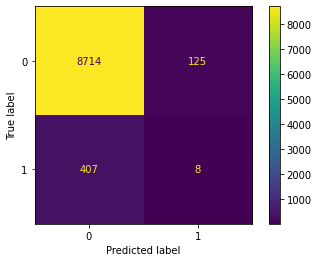

In [7]:
print_classification_report_n_mconfusion(y_predict, y_test)

## Weighted Class Linear SVM

In [8]:
filename = 'weighted_class_linear_svm.sav'
use_pretrained = True

if(use_pretrained):
  _svm = load_model(filename)
else:
  _svm = svm.SVC(kernel='linear', class_weight={1: 10})
  _svm.fit(x_train, y_train)
  save_model(_svm, filename)

y_predict = _svm.predict(x_test)

### Metriche di performance

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8878
           1       0.05      0.06      0.06       376

    accuracy                           0.92      9254
   macro avg       0.51      0.51      0.51      9254
weighted avg       0.92      0.92      0.92      9254



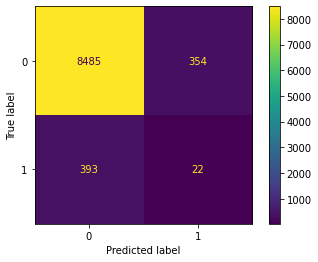

In [9]:
print_classification_report_n_mconfusion(y_predict, y_test)